# CNN for time series, exercise project 3 - Netflix

## Dependancies

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# if your Jupyter kernel crashes during this code, use this setting
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/Netflix Dataset.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5540.000000,5540.000000,5540.000000,5540.000000,5540.000000,5.540000e+03
mean,140.532640,142.672456,138.337011,140.561354,140.561354,1.569438e+07
std,182.387899,184.938036,179.723418,182.376297,182.376297,1.862414e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,4.165893,4.245714,4.080000,4.163036,4.163036,5.751000e+06
50%,35.942858,36.778572,35.346429,36.154285,36.154285,9.830450e+06
75%,282.360008,287.464989,275.742500,282.892502,282.892502,1.859220e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.234140e+08


In [6]:
df = df.drop(['Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [7]:
df.head()

,Date,Open,High
0,2002-05-23,1.156429,1.242857
1,2002-05-24,1.214286,1.225000
2,2002-05-28,1.213571,1.232143
3,2002-05-29,1.164286,1.164286
4,2002-05-30,1.107857,1.107857


In [9]:
scaler = MinMaxScaler()
num_cols = ['Open', 'High']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [10]:
df.head()

,Date,Open,High
0,2002-05-23,0.001125,0.001188
1,2002-05-24,0.001209,0.001162
2,2002-05-28,0.001208,0.001172
3,2002-05-29,0.001137,0.001076
4,2002-05-30,0.001055,0.000995


In [12]:
# instead of the date-column and old index,
# let's use a sequence number
# starting from 1 until the final row
df['sequence'] = df.index + 1
df = df.drop('Date', axis=1)

In [13]:
df.tail()

,Open,High,sequence
5535,0.896022,0.919181,5536
5536,0.919664,0.928473,5537
5537,0.934665,0.926147,5538
5538,0.927728,0.916812,5539
5539,0.923480,0.930072,5540


## Split the DataFrame into timesteps

In [43]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 20

# separate the output variables
open = df['Open'].values
high = df['High'].values

# generate timestep windows for each signal
open_windows = sliding_window_view(open, window_shape=timestep_size)
high_windows = sliding_window_view(high, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((open_windows, high_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(open_windows) + [1] * len(high_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (11042, 20)
y: (11042,)


In [44]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

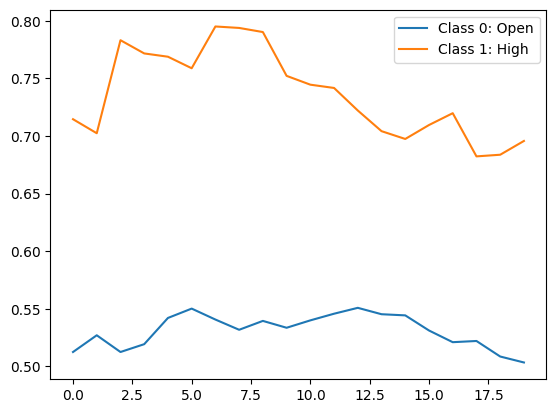

In [45]:
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: Open")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: High")
plt.legend()

 Finally we can do the train/test split

In [47]:
 # define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [48]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

7729
3313
7729
3313


In [49]:
x_train

array([[0.39610287, 0.41854597, 0.44629277, ..., 0.44239086, 0.44616267,
        0.4639958 ],
       [0.00764571, 0.00819628, 0.00829416, ..., 0.00856944, 0.00848787,
        0.00848583],
       [0.00449934, 0.00484803, 0.0048725 , ..., 0.00497038, 0.00504582,
        0.00500096],
       ...,
       [0.03725591, 0.03701937, 0.03751488, ..., 0.04930104, 0.04934998,
        0.04871989],
       [0.55727989, 0.53126728, 0.52029863, ..., 0.54171569, 0.55495322,
        0.56241013],
       [0.11548875, 0.11591817, 0.1151667 , ..., 0.12693637, 0.12818952,
        0.12832991]])

In [50]:
# convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [51]:
x_train

array([[[0.39610287],
        [0.41854597],
        [0.44629277],
        ...,
        [0.44239086],
        [0.44616267],
        [0.4639958 ]],

       [[0.00764571],
        [0.00819628],
        [0.00829416],
        ...,
        [0.00856944],
        [0.00848787],
        [0.00848583]],

       [[0.00449934],
        [0.00484803],
        [0.0048725 ],
        ...,
        [0.00497038],
        [0.00504582],
        [0.00500096]],

       ...,

       [[0.03725591],
        [0.03701937],
        [0.03751488],
        ...,
        [0.04930104],
        [0.04934998],
        [0.04871989]],

       [[0.55727989],
        [0.53126728],
        [0.52029863],
        ...,
        [0.54171569],
        [0.55495322],
        [0.56241013]],

       [[0.11548875],
        [0.11591817],
        [0.1151667 ],
        ...,
        [0.12693637],
        [0.12818952],
        [0.12832991]]])

## First Model

In [ ]:
class_names = np.array(["Open", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6993 - sparse_categorical_accuracy: 0.4956 - val_loss: 0.6935 - val_sparse_categorical_accuracy: 0.4754
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.4882 - val_loss: 0.6943 - val_sparse_categorical_accuracy: 0.4948
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.6945 - val_sparse_categorical_accuracy: 0.4858
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.4981 - val_loss: 0.6957 - val_sparse_categorical_accuracy: 0.4929
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6959 - sparse_categorical_accuracy: 0.4905 - val_loss: 0.6976 - val_sparse_categorical_accuracy: 0.4922
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.5193 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.495

<Axes: >

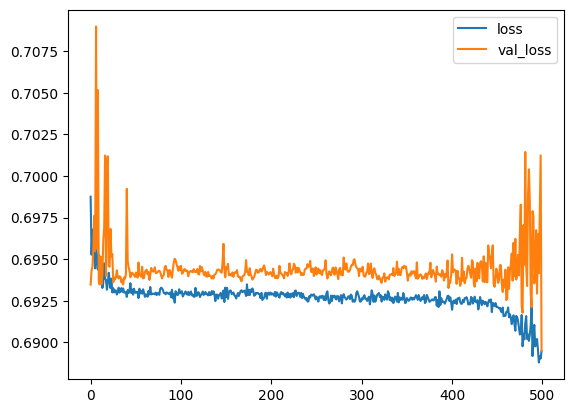

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

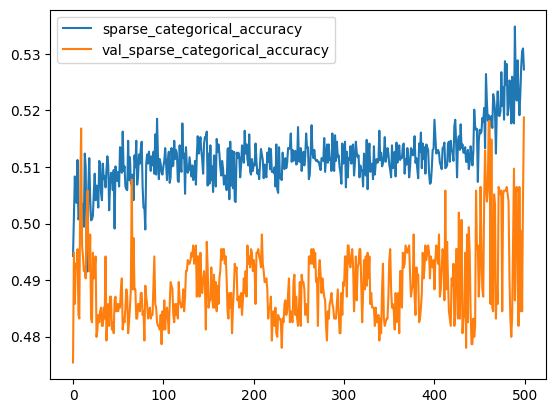

In [ ]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.6911474466323853, 0.5055840611457825]

Train data evaluation:
[0.6881915926933289, 0.526199996471405]


In [ ]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

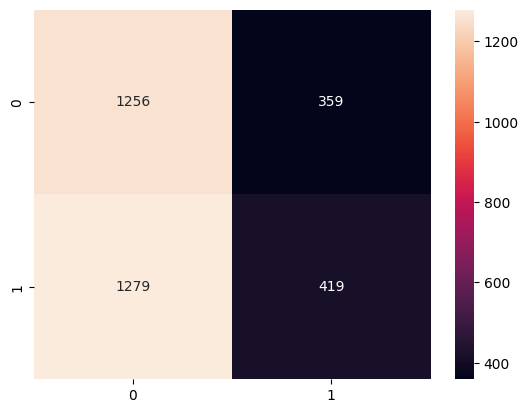

In [ ]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [ ]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61      1615
           1       0.54      0.25      0.34      1698

    accuracy                           0.51      3313
   macro avg       0.52      0.51      0.47      3313
weighted avg       0.52      0.51      0.47      3313


Model overall accuracy: 50.56%


Only 50% accuracy, it also seems to prefer to guess for only class 0. Let's try to increase the node size.

## Second Model

In [68]:
class_names = np.array(["Open", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
        keras.layers.Input(input_shape),
        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        
        # Additional Conv1D layer
        keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        # Optional: Add a Dropout layer to prevent overfitting
        keras.layers.Dropout(0.3),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),  # Increased number of units
        keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [69]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7336 - sparse_categorical_accuracy: 0.5031 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.4948
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7031 - sparse_categorical_accuracy: 0.5063 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.4955
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7003 - sparse_categorical_accuracy: 0.5156 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.4948
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7070 - sparse_categorical_accuracy: 0.4942 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.4981
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6982 - sparse_categorical_accuracy: 0.5100 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.4871
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.4876 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.49

<Axes: >

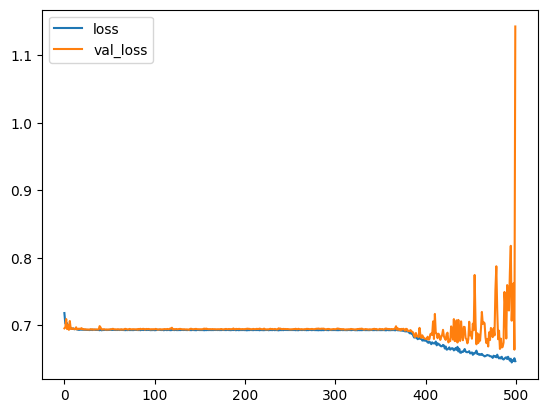

In [70]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

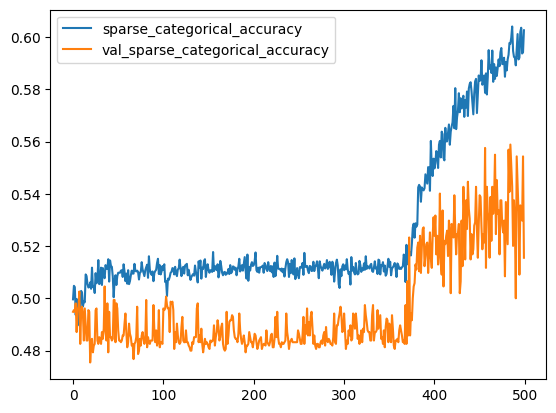

In [71]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [72]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[1.1448718309402466, 0.5270147919654846]

Train data evaluation:
[1.1505930423736572, 0.5141674280166626]


In [73]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: >

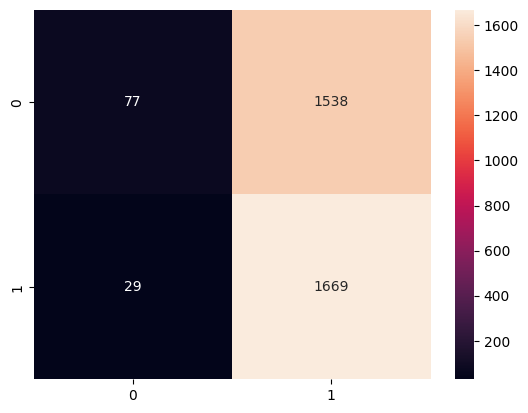

In [74]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [75]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.73      0.05      0.09      1615
           1       0.52      0.98      0.68      1698

    accuracy                           0.53      3313
   macro avg       0.62      0.52      0.39      3313
weighted avg       0.62      0.53      0.39      3313


Model overall accuracy: 52.70%


Eh, it's better, accuracy of 52,7%, but now it guesses Class 1 most of the time? Let's try to change the activation functions to use LeakyReLU instead of ReLU.

## Third Model

In [60]:
class_names = np.array(["Open", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
    keras.layers.Input(input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    
    # Additional Conv1D layer
    keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),

    # Optional: Add a Dropout layer to prevent overfitting
    keras.layers.Dropout(0.3),

    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),  # Increased number of units
    keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [61]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7172 - sparse_categorical_accuracy: 0.5050 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.4948
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.4984 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.4948
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.4917 - val_loss: 0.7027 - val_sparse_categorical_accuracy: 0.4787
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7011 - sparse_categorical_accuracy: 0.4917 - val_loss: 0.7003 - val_sparse_categorical_accuracy: 0.4955
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6966 - sparse_categorical_accuracy: 0.4961 - val_loss: 0.6957 - val_sparse_categorical_accuracy: 0.4948
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6969 - sparse_categorical_accuracy: 0.5002 - val_loss: 0.6954 - val_sparse_categorical_accuracy: 0.494

<Axes: >

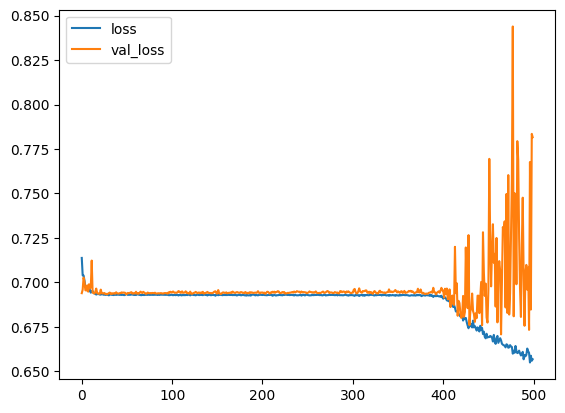

In [62]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

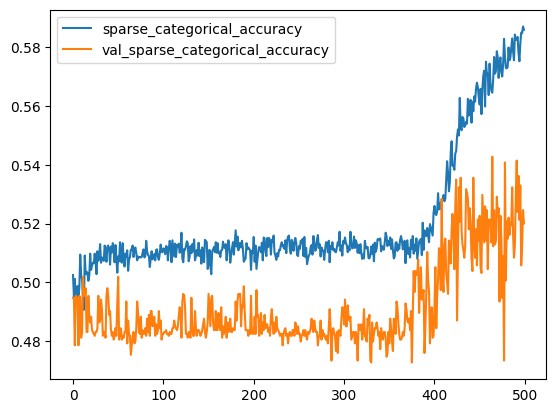

In [63]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [64]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.7599198818206787, 0.5348626375198364]

Train data evaluation:
[0.7604607939720154, 0.5290464758872986]


In [65]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: >

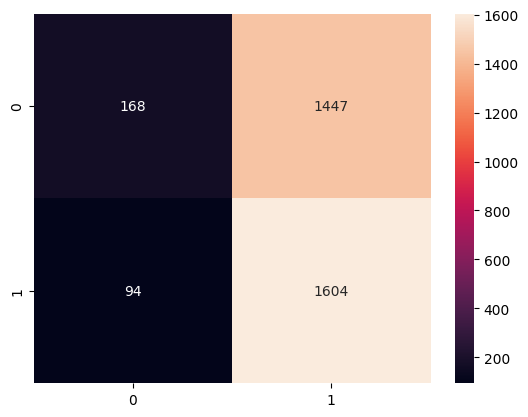

In [66]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [67]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.64      0.10      0.18      1615
           1       0.53      0.94      0.68      1698

    accuracy                           0.53      3313
   macro avg       0.58      0.52      0.43      3313
weighted avg       0.58      0.53      0.43      3313


Model overall accuracy: 53.49%


The problem persists, but the accuracy increased by like 0.7%. Maybe the model is overfitting? Let's try some regularizers.

## Fourth Model

In [76]:
class_names = np.array(["Open", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
        keras.layers.Input(input_shape),
        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same",kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        
        # Additional Conv1D layer
        keras.layers.Conv1D(filters=128, kernel_size=3, padding="same",kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        # Optional: Add a Dropout layer to prevent overfitting
        keras.layers.Dropout(0.3),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),  # Increased number of units
        keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [77]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.7948 - sparse_categorical_accuracy: 0.5064 - val_loss: 0.7444 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7456 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.5032
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7369 - sparse_categorical_accuracy: 0.5007 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.5071
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7216 - sparse_categorical_accuracy: 0.4963 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.4942
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7100 - sparse_categorical_accuracy: 0.4875 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.4948
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.4883 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.

<Axes: >

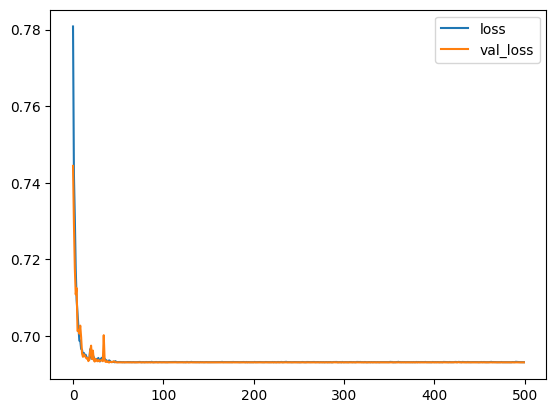

In [78]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

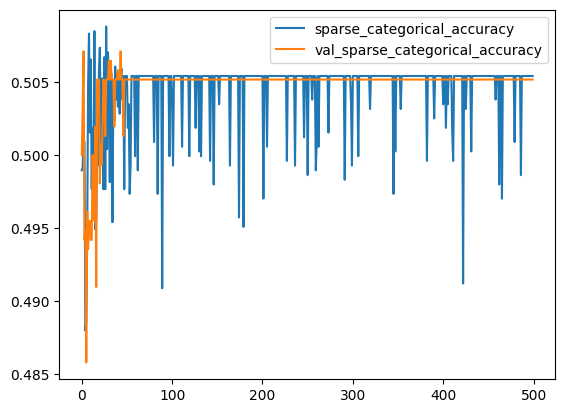

In [79]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [80]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.6934823393821716, 0.48747357726097107]

Train data evaluation:
[0.6930890679359436, 0.5053693652153015]


In [81]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Axes: >

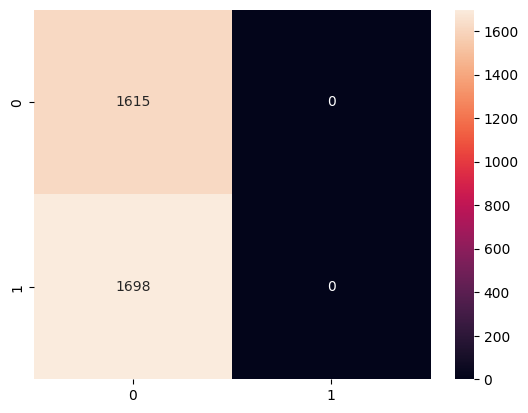

In [82]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [83]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1615
           1       0.00      0.00      0.00      1698

    accuracy                           0.49      3313
   macro avg       0.24      0.50      0.33      3313
weighted avg       0.24      0.49      0.32      3313


Model overall accuracy: 48.75%


c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

This did not really help. Now it only guesses Class 0 100% of the time. Maybe we need to try these models with 'Volume' instead of 'Open'.

## Conclusion

After having a look at these models, there definetely seems to be a problem. The models are not able to properly distinguish between both the target variables 'Open' and 'High'. I expected this result, since both have very high correlation and are basically the same value with minor difference.<br>
Increasing the Node count introduced an increase in accuracy, though the problem persists that the majority of guesses are either 'Open' or 'High' despite their actual values.<br>
Let's create a second file and try the same models with 'Volume' and 'High', instead of 'Open' and 'High'. 'Volume has almost no importance, and a bad correlation, but nevertheless, it is a different measurement.